In [1]:
from pcap_feature_parser import read_pcap
import pandas as pd
import numpy as np
import math
import wordninja

In [2]:
%%time
df = pd.DataFrame()

file_list = {'benign plain.pcap':0,
             'dns2tcp tunneling.pcap':1,
             'dnscapy tunneling.pcap':1,
             'iodine tunneling.pcap':1,
             'dnscat2_dns_tunneling_1hr.pcap':1,
             'tuns_c_00000_20180330104021.pcap':1}

for file, label in file_list.items():
    df_append = read_pcap('data/pcaps/'+file)
    df_append['Label'] = [int(label) for i in df_append.index]
    df = pd.concat([df, df_append], axis=0)

df = df.reset_index()
df = df.drop(columns='index')

Wall time: 1min 59s


In [3]:
#df.insert(1, 'Label', [int(label) for i in df.index])

def splitquery(x):
    groups = x.rsplit('.',3)
    SD = groups[0].lstrip('b\'') if len(groups)==4 else ''
    TLD = '.'.join(groups[-3:-1]).lstrip('b\'')
    return SD, TLD

df[['Subdomain','Top Level Domain']] = [splitquery(query) for query in df['Query Name']]

display(df)

,Source Path,Session,Protocol,Query Name,Payload,RR type,Label,Subdomain,Top Level Domain
0,data/pcaps/benign plain.pcap,UDP 8.8.8.8:53 > 172.17.0.2:45790,17,b'google.com.',216.58.209.46,1,0,,google.com
1,data/pcaps/benign plain.pcap,UDP 8.8.8.8:53 > 172.17.0.2:43577,17,b'facebook.com.',185.60.216.35,1,0,,facebook.com
2,data/pcaps/benign plain.pcap,UDP 8.8.8.8:53 > 172.17.0.2:42685,17,b'doubleclick.net.',172.217.20.206,1,0,,doubleclick.net
3,data/pcaps/benign plain.pcap,UDP 8.8.8.8:53 > 172.17.0.2:42685,17,b'cedexis-test.com.',103.243.254.42,1,0,,cedexis-test.com
4,data/pcaps/benign plain.pcap,UDP 8.8.8.8:53 > 172.17.0.2:55199,17,b'google-analytics.com.',172.217.16.36,1,0,,google-analytics.com
...,...,...,...,...,...,...,...,...,...
27615,data/pcaps/tuns_c_00000_20180330104021.pcap,UDP 172.17.0.2:53 > 172.17.0.3:42758,17,b'r18573.tunnel.tuns.org.',b'dzero.tunnel.tuns.org.',5,1,r18573.tunnel,tuns.org
27616,data/pcaps/tuns_c_00000_20180330104021.pcap,UDP 172.17.0.2:53 > 172.17.0.3:42758,17,b'dIUEABDEJ7NAAAQAGTRSAUAAAAMFAAAAC37CAAFUWXCI...,b'l0.tunnel.tuns.org.',5,1,dIUEABDEJ7NAAAQAGTRSAUAAAAMFAAAAC37CAAFUWXCIDO...,tuns.org
27617,data/pcaps/tuns_c_00000_20180330104021.pcap,UDP 172.17.0.2:53 > 172.17.0.3:42758,17,b'r18574.tunnel.tuns.org.',b'dIUEAAUAHWVAAAQAGD3TQUAAAAIFAAAADAALN7RA6F5T...,5,1,r18574.tunnel,tuns.org
27618,data/pcaps/tuns_c_00000_20180330104021.pcap,UDP 172.17.0.2:53 > 172.17.0.3:42758,17,b'dIUEABDEJ7RAAAQAGTRRQUAAAAMFAAAAC37CAAFUWXCI...,b'l0.tunnel.tuns.org.',5,1,dIUEABDEJ7RAAAQAGTRRQUAAAAMFAAAAC37CAAFUWXCII6...,tuns.org


In [4]:
cols = ['Label','Source Path','Session','Protocol','Query Name','Subdomain','Top Level Domain','Payload','RR type']
df = df.loc[:, cols] # reorder columns
display(df)

,Label,Source Path,Session,Protocol,Query Name,Subdomain,Top Level Domain,Payload,RR type
0,0,data/pcaps/benign plain.pcap,UDP 8.8.8.8:53 > 172.17.0.2:45790,17,b'google.com.',,google.com,216.58.209.46,1
1,0,data/pcaps/benign plain.pcap,UDP 8.8.8.8:53 > 172.17.0.2:43577,17,b'facebook.com.',,facebook.com,185.60.216.35,1
2,0,data/pcaps/benign plain.pcap,UDP 8.8.8.8:53 > 172.17.0.2:42685,17,b'doubleclick.net.',,doubleclick.net,172.217.20.206,1
3,0,data/pcaps/benign plain.pcap,UDP 8.8.8.8:53 > 172.17.0.2:42685,17,b'cedexis-test.com.',,cedexis-test.com,103.243.254.42,1
4,0,data/pcaps/benign plain.pcap,UDP 8.8.8.8:53 > 172.17.0.2:55199,17,b'google-analytics.com.',,google-analytics.com,172.217.16.36,1
...,...,...,...,...,...,...,...,...,...
27615,1,data/pcaps/tuns_c_00000_20180330104021.pcap,UDP 172.17.0.2:53 > 172.17.0.3:42758,17,b'r18573.tunnel.tuns.org.',r18573.tunnel,tuns.org,b'dzero.tunnel.tuns.org.',5
27616,1,data/pcaps/tuns_c_00000_20180330104021.pcap,UDP 172.17.0.2:53 > 172.17.0.3:42758,17,b'dIUEABDEJ7NAAAQAGTRSAUAAAAMFAAAAC37CAAFUWXCI...,dIUEABDEJ7NAAAQAGTRSAUAAAAMFAAAAC37CAAFUWXCIDO...,tuns.org,b'l0.tunnel.tuns.org.',5
27617,1,data/pcaps/tuns_c_00000_20180330104021.pcap,UDP 172.17.0.2:53 > 172.17.0.3:42758,17,b'r18574.tunnel.tuns.org.',r18574.tunnel,tuns.org,b'dIUEAAUAHWVAAAQAGD3TQUAAAAIFAAAADAALN7RA6F5T...,5
27618,1,data/pcaps/tuns_c_00000_20180330104021.pcap,UDP 172.17.0.2:53 > 172.17.0.3:42758,17,b'dIUEABDEJ7RAAAQAGTRRQUAAAAMFAAAAC37CAAFUWXCI...,dIUEABDEJ7RAAAQAGTRRQUAAAAMFAAAAC37CAAFUWXCII6...,tuns.org,b'l0.tunnel.tuns.org.',5


In [5]:
%%time

def shannon(x):
    x = str(x)
    freqs = (
        float(x.count(c))/len(x)
        for c in set(x))
    return -sum((
        prob * math.log(prob, 2)
        for prob in freqs))

#df['Query Name Entropy'] = [shannon(name) for name in df['Query Name']]
df['Subdomain Entropy'] = [shannon(name) for name in df['Subdomain']]
df['Payload Entropy'] = [shannon(name) for name in df['Payload']]


Wall time: 1.12 s


In [6]:
%%time
df['longest word Subdomain'] = [len(max(wordninja.split(name), key=len, default='')) for name in df['Subdomain']]

Wall time: 42.4 s


In [7]:
%%time
df['longest word Payload'] = [len(max(wordninja.split(name), key=len, default='')) for name in df['Payload']]

Wall time: 9.63 s


In [8]:

#     def count(x):
#         x = str(x)
#         total = len(x)
#         uppercase, lowercase, numeric, special = 0, 0, 0, 0
#         for i in range(total):
#             if x[i].isupper():
#                 uppercase += 1
#             elif x[i].islower():
#                 lowercase += 1
#             elif x[i].isdigit():
#                 numeric += 1
#             else:
#                 special += 1
#         return [total, uppercase, lowercase, numeric, special]

# #     df[['Character Count', 
# #         'Uppercase Count', 
# #         'Lowercase Count', 
# #         'Numeric Count', 
# #         'Special Char Count']] = [count(name) for name in df['Query Name']]
    
#     df[['Subdomain Character Count', 
#         'Subdomain Uppercase Count', 
#         'Subdomain Lowercase Count', 
#         'Subdomain Numeric Count', 
#         'Subdomain Special Char Count']] = [count(name) for name in df['Subdomain']]
    
#     df[['Payload Character Count', 
#         'Payload Uppercase Count', 
#         'Payload Lowercase Count', 
#         'Payload Numeric Count', 
#         'Payload Special Char Count']] = [count(name) for name in df['Payload']]

#     df['Dashes Count'] = [str(name).count('-') for name in df['Query Name']]
#     df['Slashes Count'] = [str(name).count('/') for name in df['Query Name']]
#     df['Periods Count'] = [str(name).count('.') for name in df['Query Name']]
#     df['Equal Signs Count'] = [str(name).count('=') for name in df['Query Name']]

In [9]:
%%time

def ratio(x):
    x = str(x)
    total = len(x)
    uppercase, lowercase, numeric, special = 0,0,0,0
    if total != 0:
        for i in range(total):
            if x[i].isupper():
                uppercase += 1
            elif x[i].islower():
                lowercase += 1
            elif x[i].isdigit():
                numeric += 1
            else:
                special += 1
        return [uppercase/total, lowercase/total, numeric/total, special/total]
    else:
        return 0,0,0,0

#df[['Uppercase Ratio', 'Lowercase Ratio', 'Numeric Ratio', 'Special Char Ratio']] = [ratio(name) for name in df['Query Name']]


Wall time: 0 ns


In [10]:
%%time
df[['Payload Uppercase Ratio', 'Payload Lowercase Ratio', 'Payload Numeric Ratio', 'Payload Special Char Ratio']] = [ratio(name) for name in df['Payload']]

Wall time: 295 ms


In [11]:
%%time
df[['Subdomain Uppercase Ratio', 'Subdomain Lowercase Ratio', 'Subdomain Numeric Ratio', 'Subdomain Special Char Ratio']] = [ratio(name) for name in df['Subdomain']]

Wall time: 1.18 s


In [12]:
%%time
df['Packets in Session'] = df.groupby('Session')['Session'].transform('count')

Wall time: 19.2 ms


In [13]:
%%time

#df['Avg Query Name Length (Session)'] = df.groupby('Session')['Query Name'].transform(lambda x: np.mean(x.str.len()))
df['Avg Subdomain Length (Session)'] = df.groupby('Session')['Subdomain'].transform(lambda x: np.mean(x.str.len()))


Wall time: 4.9 s


In [14]:
%%time
df['Avg Payload Length (Session)'] = df.groupby('Session')['Payload'].transform(lambda x: np.mean(x.str.len()))

Wall time: 4.56 s


In [15]:
from pprint import pprint
pprint(list(df.columns))

['Label',
 'Source Path',
 'Session',
 'Protocol',
 'Query Name',
 'Subdomain',
 'Top Level Domain',
 'Payload',
 'RR type',
 'Subdomain Entropy',
 'Payload Entropy',
 'longest word Subdomain',
 'longest word Payload',
 'Payload Uppercase Ratio',
 'Payload Lowercase Ratio',
 'Payload Numeric Ratio',
 'Payload Special Char Ratio',
 'Subdomain Uppercase Ratio',
 'Subdomain Lowercase Ratio',
 'Subdomain Numeric Ratio',
 'Subdomain Special Char Ratio',
 'Packets in Session',
 'Avg Subdomain Length (Session)',
 'Avg Payload Length (Session)']


In [16]:
print(list(df.columns)[8:])

['RR type', 'Subdomain Entropy', 'Payload Entropy', 'longest word Subdomain', 'longest word Payload', 'Payload Uppercase Ratio', 'Payload Lowercase Ratio', 'Payload Numeric Ratio', 'Payload Special Char Ratio', 'Subdomain Uppercase Ratio', 'Subdomain Lowercase Ratio', 'Subdomain Numeric Ratio', 'Subdomain Special Char Ratio', 'Packets in Session', 'Avg Subdomain Length (Session)', 'Avg Payload Length (Session)']


In [20]:
from sklearn.ensemble import RandomForestClassifier

test_grid = {'bootstrap': True,
             'n_estimators': 1000,
             'max_features': 10,
             'max_depth': 10,
             'min_samples_leaf': 0.1,
             'min_samples_split': 0.2
             }

rf_tuned = RandomForestClassifier()
rf_tuned.set_params(**test_grid)

RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=0.1,
                       min_samples_split=0.2, n_estimators=1000)

,fi,std
Avg Subdomain Length (Session),6.370006e-01,4.810969e-01
RR type,1.679862e-01,3.740227e-01
Payload Lowercase Ratio,1.499874e-01,3.572196e-01
Payload Numeric Ratio,2.899725e-02,1.678695e-01
Subdomain Entropy,1.501469e-02,1.215639e-01
longest word Subdomain,9.920320e-04,3.136838e-02
Subdomain Numeric Ratio,1.223721e-05,2.562499e-04
Subdomain Lowercase Ratio,7.979860e-06,3.758765e-05
Packets in Session,1.492629e-06,9.904262e-06
Subdomain Uppercase Ratio,2.514660e-08,7.942112e-07


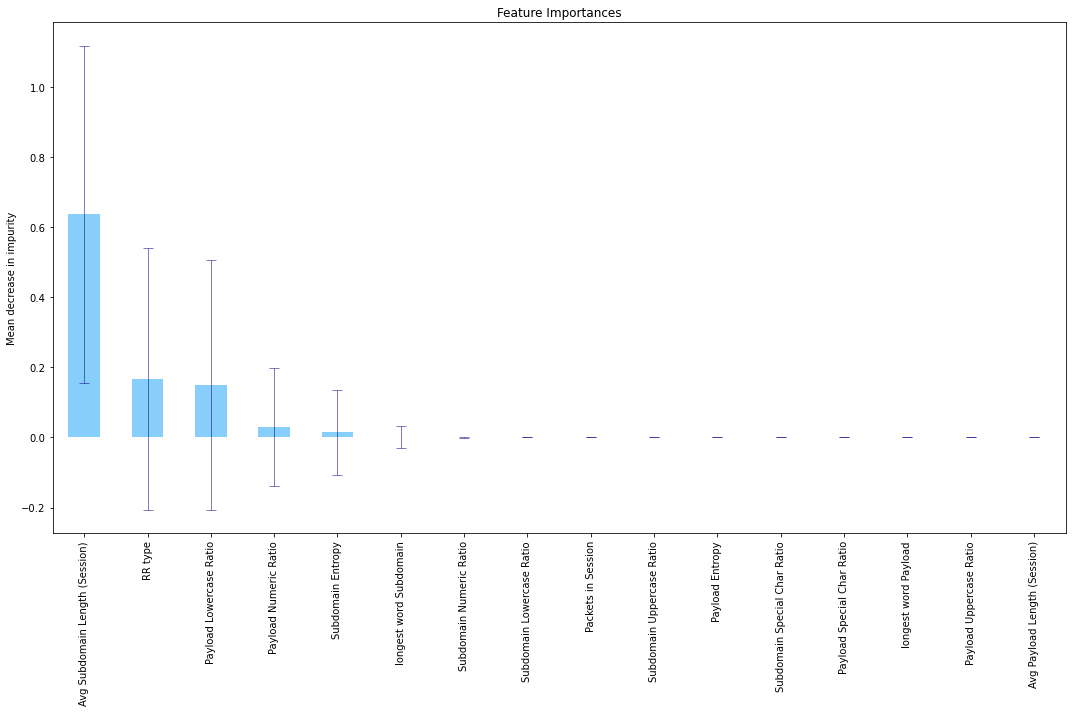

In [21]:

features = list(df.columns)[8:]
x = np.array(df.loc[:,features].fillna(0))
y = np.array(df['Label'])

rf_tuned.fit(x,y)


import matplotlib.pyplot as plt

importances = pd.DataFrame(rf_tuned.feature_importances_, columns=['fi'], index=features)
importances['std'] = np.std([tree.feature_importances_ for tree in rf_tuned.estimators_], axis=0, ddof=1)
importances.sort_values('fi', ascending=False, inplace=True)
display(importances)
fig, ax = plt.subplots(figsize=(15,10))
importances.plot.bar(yerr='std', ax=ax, error_kw=dict(capsize=5, lw=0.5, capthick=0.5), color='lightskyblue', ecolor='navy')
ax.set_title("Feature Importances")
ax.set_ylabel("Mean decrease in impurity")
ax.get_legend().remove()
fig.tight_layout()

In [19]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(rf_tuned)
sel.fit(x, y)

selected_feat = df.loc[:,features].columns[(sel.get_support())]
print(list(selected_feat))

['RR type', 'Payload Lowercase Ratio', 'Avg Subdomain Length (Session)']
